# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import beam_simulation as bs
print("Loaded from:", bs.__file__)
from beam_simulation.create_oam_list import GenerateOAM

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization,
    Flatten, Dense, Reshape, Conv2DTranspose
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


Loaded from: /Users/mpbart/Desktop/beam_project/beam_simulation/__init__.py


# Configure Set Up

In [2]:
cfg = bs.Config(
    wavelength=795e-9,
    size_x=200,
    size_y=200,
    pixel_size=1080*8e-6/200, #adjusted to approximate size of SLM
    w0=0.5e-3,
)

print("Default config now set to:")
print(bs.get_default_config())

Default config now set to:
Beam Simulation Configuration:
  Wavelength: 795.0 nm
  Beam waist (w0): 0.500 mm
  Size: 200 × 200 px
  Pixel size: 43.20 µm



# Create Modes

In [74]:
gen = GenerateOAM(
    mode_types=["LG", "HG", "IG"],
    orders={
        "LG": {"p": [0, 1], "l": [1, 2]},
        "HG": {"n": [0, 1], "m": [1, 2]},
        "IG": {"p": [2], "m": [2]}
    },
    Cn2_list=[71.8e-13, 30.2e-12, 12e-12],
    n_samples=100
)


In [ ]:
gen = GenerateOAM(
    mode_types=["LG"],
    orders={
        "LG": {"p": [0,1,1], "l": [1,2,1]}, #pairs of order numbers
    },
    Cn2_list=[71.8e-13, 30.2e-12, 12e-12], #different turbulence levels
    n_samples=400 #number of images per mode and order
)

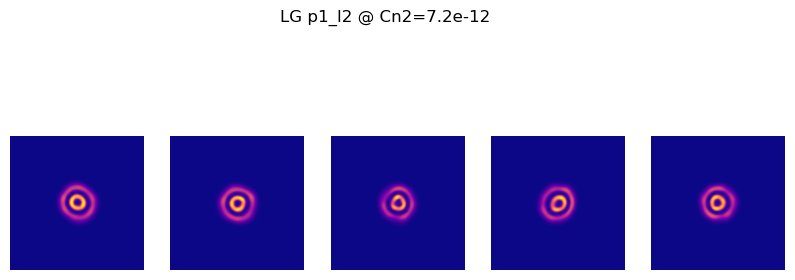

In [4]:
#Visualize a mode and order at a certain turbulence level
gen.visualize("LG", "p1_l2", Cn2=71.8e-13)

# Dividing into Training and Testing Images

In [5]:
data = gen.data
modes = ['LG', 'HG', 'IG']

images = []         #turbulent inputs
labels = []         #clean reference images
order_labels = []   #text labels like "LG_p1_l2"
crop = 30

for mode, orders in data.items():
    for order, turbulence_dict in orders.items():
        print(f"Processing {mode} {order}...")

        #Parse order string to extract indices and create clean labels
        if mode == "LG":
            parts = order.replace("p", "").replace("_l", " ").split()
            p, l = map(int, parts)
            clean = bs.lg(p=p, l=l)

        elif mode == "HG":
            parts = order.replace("n", "").replace("_m", " ").split()
            n, m = map(int, parts)
            clean = bs.hg(n=n, m=m)

        elif mode == "IG":
            parts = order.replace("p", "").replace("_m", " ").split()
            p, m = map(int, parts)
            clean = bs.ig(p=p, m=m, beam="e")

        else:
            continue
        clean = bs.propagation(clean, z=40e-2) #can optionally change distance propagated, should match z in create_oam_list.py
        clean = np.abs(clean)**2
        clean = clean / np.max(clean)  #normalize
        clean = clean[crop:-crop, crop:-crop]

        #Loop through turbulence
        for Cn2_level, image_list in turbulence_dict.items():
            for img in image_list:
                img = img[crop:-crop, crop:-crop] 

                images.append(img)
                labels.append(clean)
                order_labels.append(f"{mode}_{order}")


#Convert to arrays
images = np.array(images)
labels = np.array(labels)
order_labels = np.array(order_labels)
images = images[..., np.newaxis]
labels = labels[..., np.newaxis]

#Encode string order labels numerically
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(order_labels)

print(f"Unique classes: {len(np.unique(order_labels))}")
print(f"Classes: {label_encoder.classes_}")
print(f"Image shape: {images.shape}, Label shape: {labels.shape}")


Processing LG p0_l1...
Processing LG p0_l2...
Processing LG p1_l1...
Processing LG p1_l2...
Unique classes: 4
Classes: ['LG_p0_l1' 'LG_p0_l2' 'LG_p1_l1' 'LG_p1_l2']
Image shape: (4800, 140, 140, 1), Label shape: (4800, 140, 140, 1)


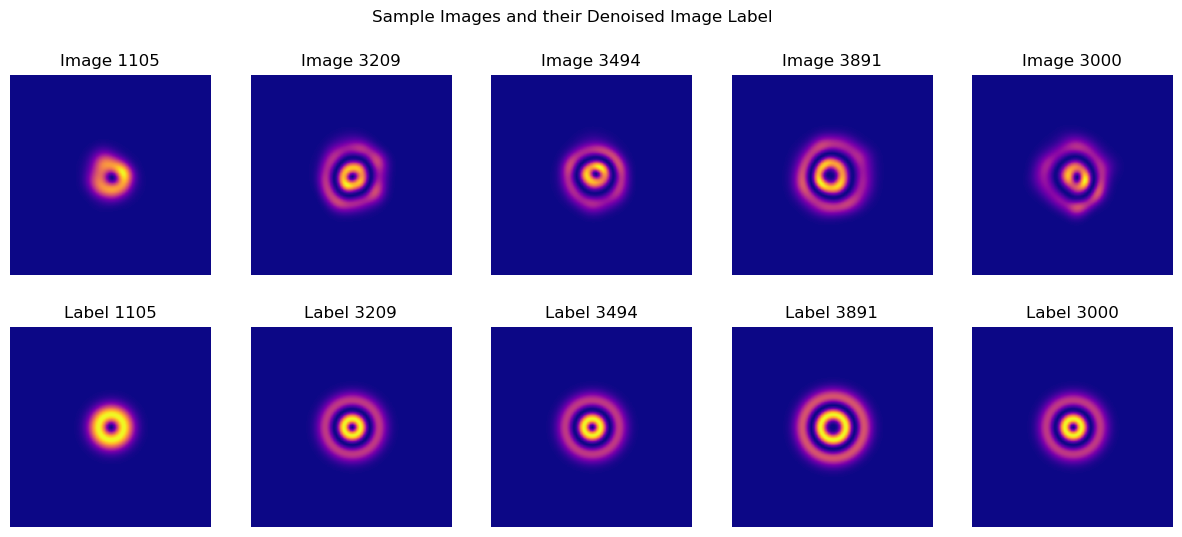

In [6]:
#Samples Images and Denoised Label
n=5
n_im = images.shape[0] 

fig, axs = plt.subplots(2, n, figsize=(3 * n, 6)) 
for i in range(n):
    random_index = np.random.randint(0, n_im)  #Randomly select idx
    axs[0, i].imshow(images[random_index], cmap='plasma')
    axs[0, i].axis('off') 
    axs[0, i].set_title(f'Image {random_index + 1}')

    axs[1, i].imshow(labels[random_index], cmap='plasma')
    axs[1, i].axis('off')
    axs[1, i].set_title(f'Label {random_index + 1}')
plt.suptitle("Sample Images and their Denoised Image Label")
plt.show()

# Generative CAE

In [7]:
class ConvAutoencoder:
    def __init__(self,
                 input_shape=(200, 200, 1),
                 latent_dim=40,
                 conv_filters=[32, 16, 8], #this enumerates how many convolutional layers there will be. 
                 kernel_size=5,
                 strides=2,
                 activation='relu',
                 decoder_activation='sigmoid',
                 use_batchnorm=True,
                 use_pool=False,
                 pool_where=None,
                 pool_size=2,
                 learning_rate=1e-3,
                 loss='mse'):
        """
        A convolutional autoencoder with simple
        encoder, decoder, and training utilities in one class.
        Note that there is no max pooling in between the convolutional layers.
        """

        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.conv_filters = conv_filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.activation = activation
        self.decoder_activation = decoder_activation
        self.use_batchnorm = use_batchnorm
        self.use_pool = use_pool
        self.pool_where = pool_where if pool_where is not None else [] #pool_where=[0,1] adds pooling after conv layers 0 and 1.
        self.pool_size = pool_size
        self.learning_rate = learning_rate
        self.loss = loss

        #Build model
        self._build()

    # ------------------------------------------------------------------
    def _build(self):
        # ----- Encoder -----
        input_img = Input(shape=self.input_shape)
        x = input_img

        #Convolutional downsampling
        for i, filters in enumerate(self.conv_filters):
            x = Conv2D(filters,
                       (self.kernel_size, self.kernel_size),
                       activation=self.activation,
                       padding='same',
                       strides=self.strides)(x)
            if self.use_batchnorm:
                x = BatchNormalization()(x)
            if i in self.pool_where:
                x = MaxPooling2D(pool_size=(self.pool_size, self.pool_size))(x)

        self.shape_before_flatten = K.int_shape(x)[1:]
        x = Flatten()(x)
        latent = Dense(self.latent_dim, name="latent_vector")(x)

        # ----- Decoder -----
        x = Dense(np.prod(self.shape_before_flatten))(latent)
        x = Reshape(self.shape_before_flatten)(x)

        #Reverse conv filters for decoder
        for i, filters in enumerate(self.conv_filters[::-1]):
            x = Conv2DTranspose(filters,
                                (self.kernel_size, self.kernel_size),
                                activation=self.activation,
                                padding='same',
                                strides=self.strides)(x)
            if self.use_batchnorm:
                x = BatchNormalization()(x)

        #Final output layer
        output = Conv2DTranspose(self.input_shape[-1],
                                 (self.kernel_size, self.kernel_size),
                                 activation=self.decoder_activation,
                                 padding='same')(x)

        #Resize to ensure macthes input size
        output = tf.image.resize(output, self.input_shape[:2])

        # ----- Models -----
        self.encoder = Model(input_img, latent, name="Encoder")
        self.decoder = Model(latent, output, name="Decoder")
        self.autoencoder = Model(input_img, output, name="Autoencoder")

        #Compile
        self.autoencoder.compile(
            optimizer=Adam(learning_rate=self.learning_rate),
            loss=self.loss
        )

    # ------------------------------------------------------------------
    def train(self, x_train, y_train=None, x_val=None, y_val=None,
              epochs=20, batch_size=32, shuffle=True):
        """Train the autoencoder."""
        if y_train is None:
            y_train = x_train
        val_data = (x_val, y_val) if x_val is not None else None

        return self.autoencoder.fit(
            x_train, y_train,
            validation_data=val_data,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=shuffle
        )

    def encode(self, x):
        return self.encoder.predict(x)

    def decode(self, z):
        return self.decoder.predict(z)

    def reconstruct(self, x): #this reconstructs the images for prediction purposes
        return self.autoencoder.predict(x)


In [9]:
#Optional Edits to Model
autoenc = ConvAutoencoder(
    input_shape=images.shape[1:],
    latent_dim=64, #size of latent vector
    conv_filters=[32, 16, 8], #determines filter sizw and number of filters
    use_batchnorm=True, #batch normalization helps with normalizing during training
    use_pool=True,
    pool_size = 2,
    pool_where = [0], #pool where determines where to add a pooling layer
    decoder_activation='linear'
)

#Splitting everything
x_train, x_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, shuffle=True)

#Training
history = autoenc.train(x_train, y_train, x_test, y_test, epochs=15, batch_size=32)

Epoch 1/15
120/120 [==============================] - 23s 188ms/step - loss: 0.0462 - val_loss: 0.0214
Epoch 2/15
120/120 [==============================] - 18s 150ms/step - loss: 0.0048 - val_loss: 0.0188
Epoch 3/15
120/120 [==============================] - 18s 152ms/step - loss: 0.0028 - val_loss: 0.0146
Epoch 4/15
120/120 [==============================] - 18s 152ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 5/15
120/120 [==============================] - 18s 151ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 6/15
120/120 [==============================] - 18s 149ms/step - loss: 9.9529e-04 - val_loss: 0.0014
Epoch 7/15
120/120 [==============================] - 18s 149ms/step - loss: 7.1105e-04 - val_loss: 5.2463e-04
Epoch 8/15
120/120 [==============================] - 19s 154ms/step - loss: 8.1733e-04 - val_loss: 3.6574e-04
Epoch 9/15
120/120 [==============================] - 18s 148ms/step - loss: 6.2802e-04 - val_loss: 3.6265e-04
Epoch 10/15
120/120 [========================

## Visualize

In [10]:
#Reconstruct the test images
xtest_decoded = autoenc.reconstruct(x_test)

30/30 [==============================] - 1s 41ms/step


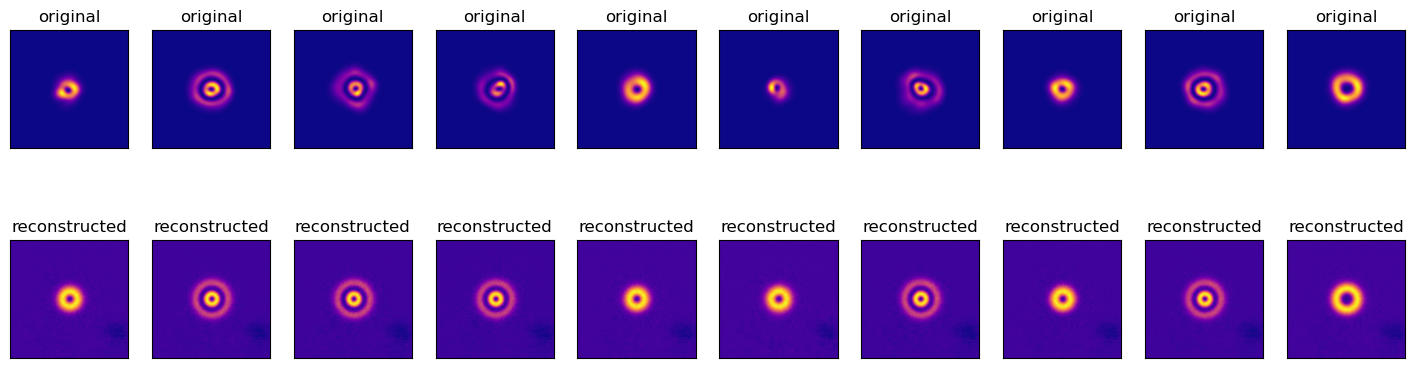

In [12]:
#Plotting some of the reconstructed beams versus their original input
n = 10
plt.figure(figsize=(18, 5))
for i in range(n):
  #display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i], cmap='plasma')
  plt.title("original")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  #display reconstruction
  ax = plt.subplot(2, n, i + 1 + 1*n)
  plt.imshow(xtest_decoded[i], cmap='plasma')
  plt.title("reconstructed")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

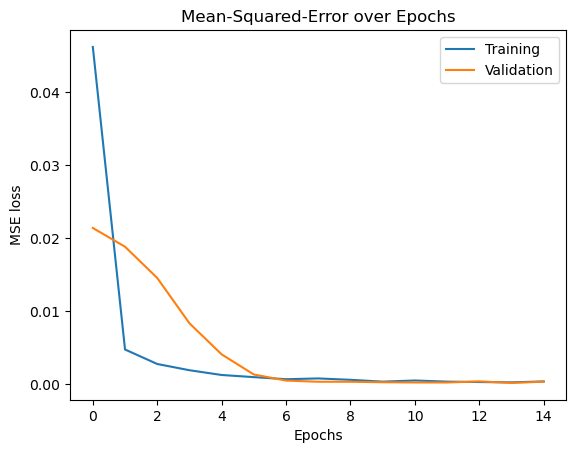

In [13]:
plt.plot(history.history["loss"],label = "Training")
plt.plot(history.history["val_loss"],label = "Validation")
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.legend()
plt.title('Mean-Squared-Error over Epochs')
plt.show()

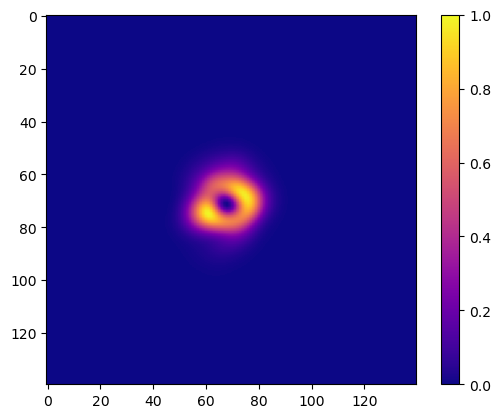

In [14]:
#Input Image
plt.imshow(x_test[0], cmap ='plasma')
plt.colorbar()


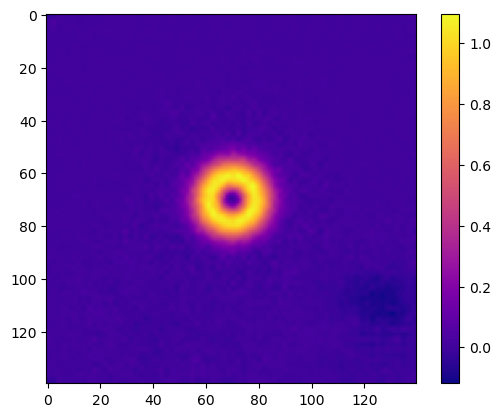

In [15]:
#Reconstructed Image
plt.imshow(xtest_decoded[0], cmap ='plasma')
plt.colorbar()